In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import math
import collections as clt
from community import best_partition,modularity
import itertools
from joblib import Parallel, delayed
import pickle
from IPython.display import display, HTML

In [2]:
plt.rcParams["figure.figsize"] = (10,7) #defining size of plots
df = pd.read_csv('reviews_full_v9-2.csv')
df.head()

,User,Date,Year,Month,Release,Band,Score,Link,Album_link,Review_title,...,Band_Genre,Combined_Genre,Key Features,Cleansed Features,Cleansed Text,Product Features,Product Features_dep,neg,neu,pos
0,SpookyApparition,July 11 2002,2002,7,Chaosphere,Meshuggah,82,https://www.metal-archives.com/reviews/Meshugg...,https://www.metal-archives.com/albums/Meshugga...,Technical metal at it's finest.,...,groove metal|thrash metal,technical thrash metal|math metal|progressive ...,originally bought|entire album|sounded variati...,originally bought|entire album|sounded variati...,I originally bought Chaosphere in late 2000......,entire album|sounded variation|grown appreciat...,tacky place|respective instruments|vocal perfo...,0.025,0.826,0.149
1,SpookyApparition,July 14 2002,2002,7,Necroticism_-_Descanting_the_Insalubrious,Carcass,88,https://www.metal-archives.com/reviews/Carcass...,https://www.metal-archives.com/albums/Carcass/...,Carcass at their finest.,...,grindcore|death metal,grindcore|melodic death metal,somewhat song structures|song structures|injec...,somewhat song structures|song structures|injec...,A midpoint between Carcass' early grind albums...,somewhat song structures|song structures|injec...,melodic variety|vocal performances|enjoyable a...,0.038,0.850,0.111
2,MarkRyan,July 15 2002,2002,7,Angels_Fall_First,Nightwish,90,https://www.metal-archives.com/reviews/Nightwi...,https://www.metal-archives.com/albums/Nightwis...,On par with their other stuff...,...,symphonic metal|power metal,symphonic power metal,general consensus|lose credibility|sung poet|b...,general consensus|lose credibility|sung poet|b...,"I'm not hard-core into metal at all, really, b...",general consensus|lose credibility|sung poet|b...,beautiful melody|beautiful example|general con...,0.026,0.771,0.202
3,Fear,July 16 2002,2002,7,Dark_Genesis,Iced_Earth,87,https://www.metal-archives.com/reviews/Iced_Ea...,https://www.metal-archives.com/albums/Iced_Ear...,Brilliance in Repackaging,...,thrash metal|power metal,heavy metal|us power metal,new album fact|old material|bought big fan|big...,new album fact|old material|bought big fan|big...,"This is not a new album, but in fact, five alb...",new album fact|old material|bought big fan|big...,different versions|original vocals|old materia...,0.031,0.723,0.246
4,Esoteric,July 16 2002,2002,7,A_Night_at_the_Opera,Blind_Guardian,70,https://www.metal-archives.com/reviews/Blind_G...,https://www.metal-archives.com/albums/Blind_Gu...,Somewhat Disappointing,...,speed metal|power metal,power metal,accurate description album|vocal lines|meaty a...,accurate description album|vocal lines|meaty a...,I've been trying for months to come up with an...,accurate description album|vocal lines|meaty a...,catchy songs|bad album|vocal lines|little line...,0.130,0.747,0.123


In [3]:
genre_group = pickle.load(open('genre_group.p','rb'))

In [4]:
#G = nx.read_gpickle('network_users.p')
users = set(df['User'])
G = nx.Graph() #network of users
B = nx.Graph() #bipartite graph between users and releases
G.add_nodes_from(users)
B.add_nodes_from(users)

posScore = 75
#construction of bipartite graph between users and releases
bandmp = {}
album_to_genre = {}

def isNaN(x):
    return x != x

for index, row in df.iterrows():
    if row['Score'] >= posScore and not B.has_edge(row['Release'] + 'R', row['User']):#positive review is defined as score >= 75
        B.add_edge(row['Release'] + 'R', row['User'])#added 'R' as some user names are the same as review names
    if isNaN(row['Combined_Genre']):
        album_to_genre[row['Release'] + 'R'] = []
    else:
        album_to_genre[row['Release'] + 'R'] = row['Combined_Genre'].split('|')
        #album_to_genre[row['Release'] + 'R'] = [genre for genre in row['Combined_Genre'].split('|') if genre in genre_group and genre_group[genre] != 'Non-metal' and genre_group[genre]!= 'Others']
        
#constructing edges, and counting the frequency (i.e. number of repeated edges)
for user in users:
    for release in B.adj[user]:
        for node in B.adj[release]:
            if node < user: #to ensure the order, with no repeats
                if not G.has_edge(user,node):
                    G.add_edge(user, node, weight = 1, albums = {release})
                else:
                    G[user][node]['weight'] += 1
                    G[user][node]['albums'].add(release)

In [5]:
G.number_of_nodes()

9317

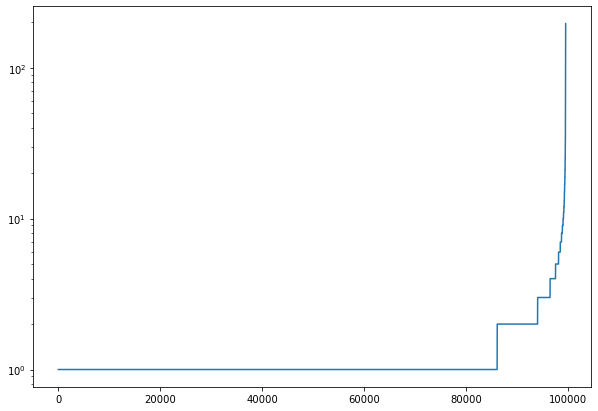

In [6]:
plt.semilogy(sorted(list(nx.get_edge_attributes(G,'weight').values())))
plt.show()

In [7]:
G_original = G.copy()

In [8]:
for u,v in G.copy().edges():
    if G[u][v]['weight'] <= 1:
        G.remove_edge(u,v)

In [9]:
sortbylen = lambda cc : len(cc)
G = G.subgraph(sorted(list(nx.connected_components(G)), key = sortbylen)[-1])

In [10]:
G.number_of_edges(), clt.Counter([len(cc) for cc in nx.connected_components(G)])

(13439, Counter({2024: 1}))

In [11]:
'''K = G.copy()
K.remove_edges_from(nx.selfloop_edges(K))
K = nx.k_core(K,3)
sortbylen = lambda cc : len(cc)
Core = K.subgraph(sorted(list(nx.connected_components(K)), key = sortbylen)[-1])'''

'K = G.copy()\nK.remove_edges_from(nx.selfloop_edges(K))\nK = nx.k_core(K,3)\nsortbylen = lambda cc : len(cc)\nCore = K.subgraph(sorted(list(nx.connected_components(K)), key = sortbylen)[-1])'

In [12]:
#Core.number_of_nodes(),Core.number_of_edges()

In [13]:
def freq_network_parr(Graph, n_iter, n_jobs, width = 'weight'):#Graph is new frequency network
    partitions = Parallel(n_jobs=n_jobs)(delayed(best_partition)(Graph, randomize = True, weight = width) for i in range(n_iter))
    #partitions = [best_partition(Graph, randomize = True, weight = 'weight') for i in range(n_iter)]
    N = int(sum([len(cc)*(len(cc)-1)/2 for cc in nx.connected_components(Graph)]))
    print(nx.number_connected_components(Graph), N, Graph.number_of_edges())
    prob = {} #key is (node 1, node 2), value is number of times they are in the same cluster/total number of iterations
    total = 0
    G = nx.Graph()
    for partition in partitions:# for n_iter number of iterations
        #partition = best_partition(Graph, randomize = True, weight = 'weight')
        mp = {}
        for user in partition:
            if partition[user] not in mp:
                mp[partition[user]]= []
            mp[partition[user]].append(user)
        for part in mp:
            for u,v in itertools.combinations(mp[part],2):
                if G.has_edge(u,v):
                    G[u][v][width] += 1
                else:
                    G.add_edge(u,v)
                    G[u][v][width] = 1
    N = int(sum([len(cc)*(len(cc)-1)/2 for cc in nx.connected_components(G)]))
    print(nx.number_connected_components(G), N, G.number_of_edges())
    return G

def no_crossedges(Graph):
    return sum([len(cc)*(len(cc)-1)/2 for cc in nx.connected_components(Graph)]) == Graph.number_of_edges()

In [14]:
nx.number_connected_components(G)

1

In [15]:
H = G.copy() #not using core for now
while not no_crossedges(H):
    H = freq_network_parr(H, 10, 4)

1 2047276 13439
1 2047276 900918
1 2047276 900918
3 1110940 477023
3 1110940 477023
5 474695 474695


In [16]:
def calc_mod(Graph, Clusters):
    part = {}
    for i,cc in enumerate(list(nx.connected_components(Clusters))):
        for node in cc:
            part[node] = i
    
    return modularity(part,Graph,weight = 'weight')
calc_mod(G, H)      

0.2639954647773757

In [17]:
[len(cc) for cc in nx.connected_components(H)]

[378, 571, 443, 524, 108]

In [18]:
clusterid = {}
for i,cc in enumerate(nx.connected_components(H)):
    for user in cc:
        clusterid[user] = i

pickle.dump(clusterid, open('cluster_ids.p', 'wb'))

In [19]:
def isNaN(x):
    return x != x

In [20]:
for i,cc in enumerate(list(nx.connected_components(H))):
    cluster = G_original.subgraph(cc)
    cxt = []
    #albumset = set()
    userset = set()
    genreset = set()
    for u,v in cluster.edges():
        for album in cluster[u][v]['albums']:
            for genre in album_to_genre[album]:
                cxt.append((u,genre))
                cxt.append((v,genre))
            
    
    cxt = clt.Counter(cxt)
    for concept in cxt.copy():
        if cxt[concept] <= 1:
            cxt.pop(concept)
        else:
            #user, album = concept
            user, genre = concept
            userset.add(user)
            #albumset.add(album)
            genreset.add(genre)
    
    #print('Shape of Context:',i,len(userset), len(albumset))
    print('Shape of Context:',i,len(userset), len(genreset))
    
    context_df = pd.DataFrame()
    cnt = 0
    for user in userset:
        arr = []
        #for album in albumset:
        for genre in genreset:
            #if (feature, genre) in cxt and cxt[(feature,genre)]/genres_all[genre] >= 0.05:
            #if (user, album) in cxt:
            if (user, genre) in cxt:
                cnt += 1
                arr.append('X')
            else:
                arr.append('')
        context_df[user] = arr
    #context_df.index = list(albumset)
    #context_df.to_csv('users-albums_'+str(i)+'.csv')
    context_df.index = list(genreset)
    context_df.to_csv('users-genres_'+str(i)+'.csv')
    print(cnt)

Shape of Context: 0 356 104
1902
Shape of Context: 1 558 131
3122
Shape of Context: 2 440 102
3017
Shape of Context: 3 508 110
2664
Shape of Context: 4 96 41
331


In [21]:
from concepts import Context

def generateConcepts(ind):
    #c = Context.fromfile('users-albums_'+str(ind)+'.csv', frmat = 'csv')
    c = Context.fromfile('users-genres_'+str(ind)+'.csv', frmat = 'csv')
    l = c.lattice
    #f = open('concepts_users-albums_'+str(ind)+'.txt','w')
    f = open('concepts_users-genres_'+str(ind)+'.txt','w')
    for x,y in l:
        f.write(str(x) + '\n\n\n' + str(y) + '\n\n\n.....................\n\n\n')
        f.write('\n')
    f.close()

In [22]:
for i in range(nx.number_connected_components(H)):
    print(i)
    generateConcepts(i)

0
1
2
3
4
